In [1]:
import os

import altair
import geopandas
import ibis
import intake
import IPython.display
import numpy
import pandas

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

In [3]:
gpr_geocode = catalog.grant_gpr_geocode.read()
city = geopandas.read_file("city_boundary.geojson")

In [4]:
lmi_pct = catalog.lmi_hud.read()
lmi_pct_city = geopandas.clip(lmi_pct, city)

In [5]:
if not os.path.exists("cpas.sqlite"):
    import s3fs
    fs = s3fs.S3FileSystem()
    fs.download("s3://hcid-cdbg-project-ita-data/cpas.sqlite", "cpas.sqlite")

con = ibis.sqlite.connect("cpas.sqlite")
gpr = con.table("grnt_gpr").execute(limit=None)

In [6]:
idx, size = zip(*[(name, sum(gpr[name].notna())) for name in gpr.columns])
counts = pandas.Series(size, idx).sort_values(ascending=False)

In [7]:
for c in counts.iteritems():
    #print(c)
    pass

In [8]:
public_access_metrics = {
    "pub_new_accs_nbr": "Members of the public with new access",
    "pub_improv_accs_nbr": "Members of the public with improved access",
}
business_assist_metrics = {
    "busi_asst_new_nbr": "New businesses assisted",
    "busi_asst_exist_nbr": "Existing businesses assisted",
    "busi_asst_cmty_need_nbr": "Businesses assisted with community need",
    "busi_asst_rehab_nbr": "Businesses rehabilitated",
    "busi_asst_exist_expnd_nbr": "Businesses expanded",
    "busi_asst_exist_reloc_nbr": "Businesses relocated",
}

job_metrics = {
    "actl_job_retn_pt_hr": "Part-time or hourly jobs retained",
    "actl_job_crt_ptlm_hr": "Low-mod part-time jobs created",
    "actl_job_retn_ft_nbr": "Full-time jobs retained",
    "actl_job_retn_ptlm_hr": "Low-mod part-time or hourly jobs retained",
    "actl_job_retn_ftlm_nbr": "Low-mod full-time jobs retained",
    "actl_job_crt_ftlm_nbr": "Low-mod full-time jobs created",
    "actl_job_crt_ft_nbr": "Full-time jobs created",
    "actl_job_crt_pt_hr": "Part-time or hourly jobs created",
}

In [9]:
cols = {
    "grnt_gpr_id": "Grant GPR ID",
    "dept": "Department",
    "yr": "Year",
    "proj_nm": "Project Name",
    "proj_addr": "Address",
    "proj_desc": "Description",
    "fund_amt": "Funding",
    "accmplsh_narrtv": "Accomplishment Status",
}

def subset_data(gpr, metrics):
    # Subset the projects
    projects = (
        gpr
        [numpy.logical_or.reduce([gpr[c].notna() for c in metrics])]
        .filter(list(cols.keys())+list(metrics.keys()) + ["geometry"])
        .rename(columns={**cols, **metrics, "geometry": "Location"})
        .set_geometry("Location")
        .assign(
            Year=lambda x: pandas.to_datetime(x.Year.astype("str")),
            Department=lambda x: x.Department.str.upper(),
        ).replace({"Department": "EWD"}, "EWDD")
        .reset_index(drop=True)
    )
    projects = projects.assign(**{
            f"{m} per million $": projects[m]/projects["Funding"]*1e6 for m in metrics.values()
    })
    return projects

def plot_metrics(projects, metrics):
    # Create the base chart
    select = altair.selection_single()

    base = altair.Chart().mark_point().encode(
        x=altair.X("Funding:Q",  scale=altair.Scale(type="log", base=10)),
        color=altair.condition(select, 'Department:N', altair.ColorValue('gray')),
        tooltip=list(cols.values()),
    ).add_selection(select)

    # Repeat for the metrics
    ncols = 3
    nrows = int(numpy.ceil(len(metrics)/ncols))
    chart = altair.vconcat(data=projects[projects.Funding > 0].drop(columns=["Location"]))
    for i in range(nrows):
        row = altair.hconcat()
        for j in range(ncols):
            idx = i*nrows+j
            if idx > len(metrics)-1:
                continue
            encoding = list(metrics.values())[idx]
            row |= base.encode(y=altair.Y(encoding, type="quantitative"))
        chart &= row
    return chart


In [10]:
metrics = business_assist_metrics
projects = subset_data(gpr_geocode, metrics)
plot_metrics(projects, metrics)

alt.VConcatChart(...)

In [11]:
if metrics == job_metrics:
    topline = "Jobs created or retained per million $"
    projects[topline] = projects[
        [m for m in job_metrics.values() if "Low-mod" not in m]
    ].sum(axis=1)/projects.Funding*1.e6
elif metrics == business_assist_metrics:
    topline = "Businesses assisted per million $"
    projects[topline] = projects[
        [m for m in business_assist_metrics.values()]
    ].sum(axis=1)/projects.Funding*1.e6
elif metrics == public_access_metrics:
    topline = "Members of the public with new or improved access per million $"
    projects[topline] = projects[
        [m for m in public_access_metrics.values()]
    ].sum(axis=1)/projects.Funding*1.e6

In [12]:
council = geopandas.read_file("https://opendata.arcgis.com/datasets/76104f230e384f38871eb3c4782f903d_13.geojson")

In [13]:
gprojects = geopandas.sjoin(
    projects,
    lmi_pct_city[["Lowmod_pct", "geometry"]].rename(columns={"Lowmod_pct": "Percent Low/Moderate Income"}),
    op="within",
    how="left"
).drop(columns=["index_right"])

In [14]:
gprojects = geopandas.sjoin(
    gprojects,
    council[["District_Name", "geometry"]].rename(columns={"District_Name": "Council District"}),
    how="inner",
    op="within",
).drop(columns=["index_right"])

In [15]:
gprojects = gprojects.drop_duplicates(subset=["Year", "Project Name"]).assign(
    Date=(
        gprojects
        .groupby([gprojects.Year.dt.year, gprojects["Council District"]])
        .Year.
        transform(
            lambda x: x + pandas.timedelta_range(
                start="1 day",
                end="365 days",
                periods=len(x)
            )
        )
    )
)

In [16]:
# choose the top metric as a stand-in for showing high-performing outliers
#metric = projects[metrics.values()].sum().sort_values(ascending=False).index[0] + " per million $"
metric = topline
ranked = projects[projects.Funding > 0].sort_values(
    [metric, "Funding"],
    ascending=[False, True]
).set_index("Grant GPR ID")
high_performing = ranked.dropna(subset=[metric]).head(100)
low_performing = ranked[ranked[metric] == 0].iloc[::-1]

In [17]:
if metrics == job_metrics:
    ranked.to_file("s3://hcid-cdbg-project-ita-data/gpr_jobs_metrics.geojson", driver="GeoJSON")
elif metrics == public_access_metrics:
    ranked.to_file("s3://hcid-cdbg-project-ita-data/gpr_public_access_metrics.geojson", driver="GeoJSON")
elif metrics == business_assist_metrics:
    ranked.to_file("s3://hcid-cdbg-project-ita-data/gpr_business_metrics.geojson", driver="GeoJSON")

In [18]:
altair.Chart(gprojects).mark_circle(
    opacity=0.8,
    stroke='black',
    strokeWidth=1,
).encode(
    x="Date:T",
    y="Council District:N",
    size=altair.Size("Funding:Q", scale=altair.Scale(range=[0,1.e4])),
    #color="Percent Low/Moderate Income:Q",
    color=altair.Color(f"{metric}:Q", scale=altair.Scale(reverse=False, scheme="cividis")),
    tooltip=list(cols.values())+list(metrics.values()),
).properties(
    width=800,
    height=800,
)

alt.Chart(...)

In [19]:
def display_table(df):
    return df.assign(
        Funding=df.Funding/1.e6,
        Year=df.Year.dt.year,
    ).filter(
        [
            "Year",
            "Project Name",
            "Department",
            metric,
            "Funding",
            "Description",
            "Accomplishment Status"
        ]
    ).reset_index().style.hide_index()

In [20]:
display(IPython.display.Markdown("# High-Performing Projects"))
display_table(high_performing)

# High-Performing Projects

Grant GPR ID,Year,Project Name,Department,Businesses assisted per million $,Funding,Description,Accomplishment Status
372,2003,HUNTINGTON COMMERCIAL FACADE PROJECT,CDD/NDD,533.333333,0.030000,"PROVIDE ARCHITECTURAL DESIGN, SECURE PERMITS, AND CONTRUCTFACADE IMPROVEMENTS FOR A TWO-STORY MIXED-USE BUILDINGLOCATED IN EL SERENO.",(PY05): PROJECT IS UNDERWAY AND DISCUSSIONS HAVE BEEN INITIATED WITH THE COUNCIL DISTRICT OFFICE AND MAYOR'S OFFICE TO DETERMINE BEST USE OF THE REMAINING FUNDS.. (PY08): PROCUREMENT OF A CONSTRUCTION MANAGER AND AN ARCHITECT WERE COMPLETED.A GENE
1860,2017,LA BUSINESS SOURCE PROGRAM,EWDD,305.000000,0.200000,"THE LOS ANGELES BUSINESS SOURCE CENTER SYSTEM WILL BE OPERATED BY NINE COMMUNITY-BASED ORGANIZATIONS (ONE FOR EACH SERVICE ARE) WITH EXPERTISE AND EXPERIENCE IN PROVIDING TECHNICAL ASSISTANCE TO BUSINESSES. THE TRAINING COMPONENTS TARGET MICROENTERPRISES, INCLUDING PRESTARTUPS AND STARTUPS, AND OPERATING SMALL BUSINESS POPULATIONS. ACTIVITY WILL SERVE THE EAST LA AREA AND WILL BE CARRIED OUT BY BARRIO PLANNERS, INC. CDBG FUNDS WILL BE USED TO PROVIDE BUSINESS SERVICES, INCLUDING: TECHNICAL ASSISTANCE, BUSINESS ASSESSMENT, BUSINESS & MARKETING PLAN DEVELOPMENT, ACCESS TO CAPITAL, LOAN PACKAGING, SITE FINDING ASSISTANCE, FINANCIAL MANAGEMENT, TECHNOLOGY TRAINING, E-COMMERCE, HUMAN RESOURCES AND NETWORKING. SERVICES WILL LEAD TO BUSINESS GROWTH AND JOB CREATIONRETENTION THAT WILL BE MADE AVAILABLE TO LOW-MOD INCOME PERSONS.",0
111,2003,HUNTINGTON COMMERCIAL FACADE PROJECT,CDD/NDD,266.666667,0.030000,"PROVIDE ARCHITECTURAL DESIGN, SECURE PERMITS, AND CONTRUCTFACADE IMPROVEMENTS FOR A TWO-STORY MIXED-USE BUILDINGLOCATED IN EL SERENO.",(PY05): PROJECT IS UNDERWAY AND DISCUSSIONS HAVE BEEN INITIATED WITH THE COUNCIL DISTRICT OFFICE AND MAYOR'S OFFICE TO DETERMINE BEST USE OF THE REMAINING FUNDS.. (PY08): PROCUREMENT OF A CONSTRUCTION MANAGER AND AN ARCHITECT WERE COMPLETED.A GENE
232,2001,TNI - Phase II - Valley Glen,CDD/NDD,200.000000,0.050000,"OUTREACH, PLANNING AND DESIGN FOR FACADE IMPROVEMENTS.","(PY01): PHASE I REPORT WHICH INCLUDES PROBLEMS, OBJECTIVES, SCOPE OF SERVICES AND DELIVERABLES, AS-BUILD AND FACADE CONCEPT DESIGN STUDIES 50% COM- PLETED.. (PY05): WITH THE LIMITED FUNDING, CDD DETERMINED THAT THE PROJECT WHICH WOULD BE MOST BENEFICIAL"
1869,2017,LA BUSINESS SOURCE PROGRAM,EWDD,155.000000,0.200000,"PACE will use CDBG funds to provide business services in the Mid City area including technical assistance, business & marketing plan development, access to capital, loan packaging, site finding assistance, financial management and technology training, e-commerce, human resource and networking services to lead to business growth and job creationretention available to low-moderate income residents.",0
1871,2017,LA BUSINESS SOURCE PROGRAM,EWDD,150.000000,0.200000,"PACE will use CDBG funds to serve the Central West LA area with business services including technical assistance, business assessment, business & marketing plan development, access to capital, loan packaging, site finding assistance, financial management, technology training, e-commerce, human resources and networking services which will lead to business growth and job creationretention made available to low moderate income residents.",0
1865,2017,LA BUSINESS SOURCE PROGRAM,EWDD,133.333333,0.300000,"THE LOS ANGELES BUSINESS SOURCE CENTER SYSTEM WILL BE OPERATED BY NINE COMMUNITY-BASED ORGANIZATIONS (ONE FOR EACH SERVICE ARE) WITH EXPERTISE AND EXPERIENCE IN PROVIDING TECHNICAL ASSISTANCE TO BUSINESSES. THE TRAINING COMPONENTS TARGET MICROENTERPRISES, INCLUDING PRESTARTUPS AND STARTUPS, AND OPERATING SMALL BUSINESS POPULATIONS. MICRO-ENTERPRISE ACTIVITIES THAT SERVE THE EAST LA AREA AND WILL BE CARRIED OUT BY BARRIO PLANNERS, INC. CDBG FUNDS WILL BE USED TO PROVIDE BUSINESS SERVICES, INCLUDING: TECHNICAL ASSISTANCE, BUSINESS ASSESSMENT, BUSINESS & MARKETING PLAN DEVELOPMENT, ACCESS TO CAPITAL, LOAN PACKAGING, SITE FINDING ASSISTANCE, FINANCIA

In [21]:
display(IPython.display.Markdown("# Low-Performing Projects"))
display_table(low_performing)

# Low-Performing Projects

Grant GPR ID,Year,Project Name,Department,Businesses assisted per million $,Funding,Description,Accomplishment Status
2393,2009,Section 108 Loan Dolby / Kodak Theater,EWDD,0.000000,28.823000,Capital improvements to the Dolby (formerly Kodak) Theater in Hollywood to accommodate the Cirque du Soleil performances.,(PY17): Project was completed in 2011 and loan was fully disbursed. However Cirque Dul Soleil performance was cancelled two years after loan was fully repaid. Accomplishment data is best effort on reporting national objective and job creation but project failed to meet 51% low / moderate income requirement.
2395,2008,Section 108 Loan 959 Seward,EWDD,0.000000,22.725000,"Section 108 loan for eligible pre constructionsoft costs to support development of a 245,000 square foot office, campus-like development with landscaped courtyard and onsite amenities.","(PY17): Construction was completed in 2015. Project is approximately 50% occupied. Developer is still in leasing effort. Project turned in first job report in 2018.. (PY18): THRU 4TH QTR PY 2018: CONSTRUCTION OF THE PROJECT HAS BEEN COMPLETED IN 2015. PROJECT IS NOT FULLY OCCUPIED, JOB REPORT HAS BEEN SUBMITTED EVERY YEAR. EDD WILL MONITOR UNTIL CONTRACTUAL GOAL IS MET."
2389,2008,Section 108 Loan 5860 W Jefferson Building (RAD Beverly),EWDD,0.000000,18.200000,"Acquisition of real property, financing and pre-development costs associated with development of an office building",(PY17): Cancel this project. The developer passed away and 108 loan was fully repaid by trustee in January 2015. Project was not completed and no jobs were reported.
1899,2008,Section 108 Loan 5860 Jefferson Building (RAD Beverly),EWDD,0.000000,18.200000,"Acquisition of real property, financing and pre-development costs associated with development of an office building",0
1904,2011,Section 108 Loan Las Villas Medical Office & Retail Project,EWDD,0.000000,16.860000,Construction of a mixed-use medical office and retail building.,0
2402,2010,Section 108 Loan One Santa Fe Mixed Use,EWDD,0.000000,14.630000,"Financing for a ground lease, construction, soft costs for development of a mixed use project including 79,000 sq ft of commercial space and 154 parking spaces.","(PY17): Section 108 loan was fully funded, project was completed in 2015. Project owner has been reporting jobs for the past two years.. (PY18): THRU 4TH QTR PY 2018: CONSTRUCTION OF THE PROJECT HAS BEEN COMPLETED IN 2015. DEVELOPER HAS BEEN REPORTING JOBS FOR THE PAST YEARS. EDD WILL CONTINUE MONITORING JOBS UNTIL OCCUPANCY STABILIZES."
2388,2008,Section 108 Loan NoHo III,EWDD,0.000000,13.965000,Section 108 loan for construction of a transit-oriented development with new Class A office space. Changed from SBA to LMJ per revised PEP 152018.,(PY17): City loan was paid off 12/2013. National objective job creation documented as presumed low / moderate income since project met both Census Tract and Block Group poverty rate.
2409,2011,Section 108 Loan The Vermont,EWDD,0.000000,12.500000,"Development of the non-residential portions of a new mixed use complex of two high rise towers 17 and 22 stories each with about 35,000 sq ft of retail space.",(PY17): Project was completed and sold to a private developer in 2014. Section 108 loan was fully paid off in 7/2014 but continues to report jobs. Activity will be open one more year for more job reporting.. (PY18): THRU 4TH QTR PY 2018: PROJECT HAS BEEN CONSTRUCTED AND IS CURRENTLY STABILIZED WITH COMMERCIAL/RETAIL TENANTS. SEC 108 LOAN WAS FULLY PAID BACK. NATIONAL OBJECTIVE LMJ IS MET.
2371,1999,Section 108 Loan Goodyear Industrial Tract,EWDD,0.000000,10.400000,"Two Projects:Slauson Central project used $6,583,000 for acquisition for environmental remediation and development and the Avalon Park Project used $3,817,000 for predevelopment, rehabilitation and construction costs for an industrial facility.",(PY17): Above accomplishment was performed by Slauson Central Project. Jobs were documented as presume

<AxesSubplot:>

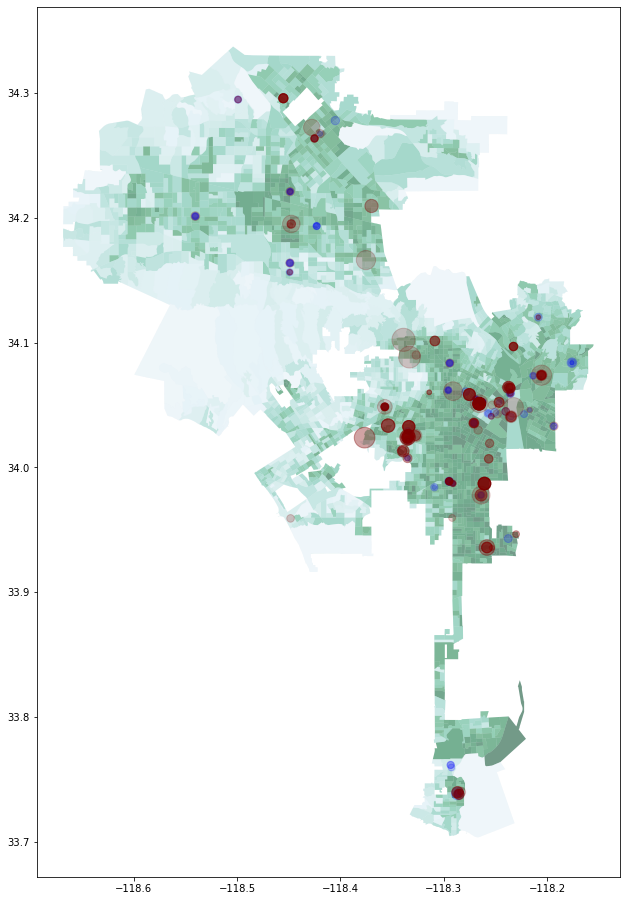

In [22]:
ax = city.plot(alpha=0.1, figsize=(16,16))
lmi_pct_city.plot(ax=ax, cmap="BuGn", column="Lowmod_pct", alpha=0.5)

high_performing[high_performing.within(city.iloc[0].geometry)].plot(markersize=numpy.sqrt(high_performing.Funding)/10., ax=ax, color="blue", alpha=0.2)
low_performing[low_performing.within(city.iloc[0].geometry)].plot(markersize=numpy.sqrt(low_performing.Funding)/10., ax=ax, color="maroon", alpha=0.2)